<img src="https://farm66.staticflickr.com/65535/49055715328_092031af74_o.png"  width="150" />

### CBPF - Centro Brasileiro de Pesquisas Físicas

# Projeto final do curso de Análise de big data e Astroinformática

### João Paulo Correia de França
### contato: joao.contato505@gmail.com


### Professor: Clécio R. de Bom

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,ZeroPadding2D,Activation
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
import time

2021-11-19 14:49:07.480478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-19 14:49:07.480553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
path = './'

In [3]:
# images path

files_names = os.listdir(path+'/LensPop/images/')

print('Current strong lensing systems on path: {:4.0f}'.format(len(files_names)))

Current strong lensing systems on path: 22641


In [4]:
# Catalog simulation parameters (true values)
lenses_DESc = pd.read_csv(path+'/lenses_DESc.txt',
                          sep=' ',
                          comment='#',
                          names=['id', 'zl', 'zs', 'b', 'sig_v', 'ql', 'rl', 'lens_g', 'lens_r', 'lens_i', 'xs', 'ys', 'qs', 'ps', 'rs', 'source_g', 'source_r', 'source_i', 'mu_s', 'g_band_coadd_seeing', 'g_band_coadd_signal_to_noise', 'r_band_coadd_seeing', 'r_band_coadd_signal_to_noise', 'i_band_coadd_seeing'])
lenses_DESc.head()

,id,zl,zs,b,sig_v,ql,rl,lens_g,lens_r,lens_i,...,rs,source_g,source_r,source_i,mu_s,g_band_coadd_seeing,g_band_coadd_signal_to_noise,r_band_coadd_seeing,r_band_coadd_signal_to_noise,i_band_coadd_seeing
0,0,0.320,1.784,1.497,265.112,0.771,1.330,19.961,18.086,17.442,...,131.188,0.290,6.413,1.352,37.000,1.352,19.368,1.352,11.432,32.021
1,1,0.402,1.790,1.372,264.665,0.811,0.819,20.778,18.833,18.103,...,35.232,0.408,4.585,1.352,22.528,1.352,11.003,1.352,9.419,19.750
2,3,0.569,1.285,1.361,318.578,0.671,0.853,21.374,19.530,18.255,...,113.910,0.290,8.931,1.352,32.892,1.352,22.761,1.352,16.575,28.284
3,4,0.189,3.385,1.686,257.082,0.709,2.291,18.166,16.757,16.249,...,125.445,0.321,7.212,1.352,23.054,1.352,15.983,1.352,9.900,17.660
4,5,0.568,1.057,0.658,242.661,0.768,0.409,22.679,20.836,19.562,...,53.932,0.008,156.589,1.352,0.002,1.352,21.890,1.352,25.334,0.000


In [5]:
# not all images have information in lenses_DESc.txt. In order to avoid some trouble, lets perform a cut on data
data_cut = []
for i in range(0, len(files_names)):
    if int(files_names[i]) in np.array(lenses_DESc['id']):
        #if len(data_cut) < 500:
        data_cut.append(int(files_names[i]))
        
print('Strong lensing systems (after cut) on path: {:4.0f}'.format(len(data_cut)))

Strong lensing systems (after cut) on path: 18598


In [6]:
# split our data in training and test dataset with ration 80 - 20 %
np.random.seed(42)
files_names_train, files_names_test = train_test_split(data_cut, test_size=0.2)
print(len(files_names_train), len(files_names_test))

14878 3720


In [7]:
# split our data in training and validation dataset with ration 90 - 10 %
np.random.seed(42)
files_names_train, files_names_val = train_test_split(files_names_train, test_size=0.1)
print(len(files_names_train), len(files_names_test), len(files_names_val))

13390 3720 1488


In [8]:
bayesian_systems=os.listdir(path+'/output/')

bayesian_systems = np.array(bayesian_systems, dtype=int)

In [9]:
# removing bayesian systems in train and validation data set and adding in the test dataset
idx_train = []
idx_val = []
for i in range(0, len(bayesian_systems)):
    if bayesian_systems[i] in files_names_train:
        idx_train.append(np.where(files_names_train==bayesian_systems[i])[0][0])
    if bayesian_systems[i] in files_names_val:
        idx_val.append(np.where(files_names_val==bayesian_systems[i])[0][0])
    if bayesian_systems[i] not in files_names_test:
        files_names_test.append(bayesian_systems[i])
    
files_names_train=np.delete(files_names_train, idx_train)
files_names_val=np.delete(files_names_val, idx_val)

# result
print(len(files_names_train), len(files_names_test), len(files_names_val))

13370 3742 1486


In [10]:
# train
x_train = []
y_train = []
for i in range(0, len(files_names_train)):
    #print(i)
    x_train.append(np.array([fits.open(path+'/LensPop/images/'+str(files_names_train[i])+"/image_g_SDSS.fits")[0].data, fits.open(path+'/LensPop/images/'+str(files_names_train[i])+"/image_r_SDSS.fits")[0].data, fits.open(path+'/LensPop/images/'+str(files_names_train[i])+"/image_i_SDSS.fits")[0].data]))
    y_train.append(float(lenses_DESc["b"][lenses_DESc["id"]==files_names_train[i]]))

# test
x_test = []
y_test = [] # true values
for i in range(0, len(files_names_test)):
    #print(i)
    x_test.append(np.array([fits.open(path+'/LensPop/images/'+str(files_names_test[i])+"/image_g_SDSS.fits")[0].data, fits.open(path+'/LensPop/images/'+str(files_names_test[i])+"/image_r_SDSS.fits")[0].data, fits.open(path+'/LensPop/images/'+str(files_names_test[i])+"/image_i_SDSS.fits")[0].data]))
    y_test.append(float(lenses_DESc["b"][lenses_DESc["id"]==files_names_test[i]]))

# val
x_val = []
y_val = [] 
for i in range(0, len(files_names_val)):
    #print(i)
    x_val.append(np.array([fits.open(path+'/LensPop/images/'+str(files_names_val[i])+"/image_g_SDSS.fits")[0].data, fits.open(path+'/LensPop/images/'+str(files_names_val[i])+"/image_r_SDSS.fits")[0].data, fits.open(path+'/LensPop/images/'+str(files_names_val[i])+"/image_i_SDSS.fits")[0].data]))
    y_val.append(float(lenses_DESc["b"][lenses_DESc["id"]==files_names_val[i]]))

In [11]:
# transform into arrays and move some axis
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

x_val = np.array(x_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

x_train = np.moveaxis(x_train, 1, 2)
x_train = np.moveaxis(x_train, 3, 2)

x_test = np.moveaxis(x_test, 1, 2)
x_test = np.moveaxis(x_test, 3, 2)

x_val = np.moveaxis(x_val, 1, 2)
x_val = np.moveaxis(x_val, 3, 2)

print(x_train.shape, x_test.shape, x_val.shape)

(13370, 76, 76, 3) (3742, 76, 76, 3) (1486, 76, 76, 3)


In [12]:
# Our deep learning algorithm 
inputs = tf.keras.Input(shape=(76, 76, 3))

x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = tf.keras.layers.Dropout(rate=0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = 'adam',
    loss = 'mse'
)

gen = tf.keras.preprocessing.image.ImageDataGenerator()

batch_size=32
start = time.perf_counter()
generator = gen.flow(x_train, y_train, batch_size = batch_size)

history = model.fit_generator(
    generator,
    steps_per_epoch=len(x_train)/batch_size,
    epochs=20,
    validation_data = (x_val, y_val),
    validation_steps = len(x_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]

)

2021-11-19 14:57:09.276740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-19 14:57:09.282330: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-19 14:57:09.283601: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-0SVSQGR): /proc/driver/nvidia/version does not exist
2021-11-19 14:57:09.295982: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_6721/1136489678.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed 

Epoch 1/20
  1/417 [..............................] - ETA: 15:19 - loss: 131.6888

2021-11-19 14:57:12.586747: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29859840 exceeds 10% of free system memory.


  2/417 [..............................] - ETA: 1:18 - loss: 428.9514 

2021-11-19 14:57:12.792588: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29859840 exceeds 10% of free system memory.


  3/417 [..............................] - ETA: 1:23 - loss: 292.0796

2021-11-19 14:57:12.999735: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29859840 exceeds 10% of free system memory.


  4/417 [..............................] - ETA: 1:29 - loss: 220.5221

2021-11-19 14:57:13.240513: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29859840 exceeds 10% of free system memory.
2021-11-19 14:57:13.415284: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29859840 exceeds 10% of free system memory.


417/417 [==============================] - 70s 163ms/step - loss: 3.0371 - val_loss: 0.1022
Epoch 2/20
417/417 [==============================] - 65s 155ms/step - loss: 0.0903 - val_loss: 0.0838
Epoch 3/20
417/417 [==============================] - 62s 148ms/step - loss: 0.0950 - val_loss: 0.0620
Epoch 4/20
417/417 [==============================] - 61s 145ms/step - loss: 0.0606 - val_loss: 0.0540
Epoch 5/20
417/417 [==============================] - 63s 152ms/step - loss: 0.0503 - val_loss: 0.0441
Epoch 6/20
417/417 [==============================] - 63s 151ms/step - loss: 0.0549 - val_loss: 0.1752
Epoch 7/20
417/417 [==============================] - 65s 155ms/step - loss: 0.0489 - val_loss: 0.0455
Epoch 8/20
417/417 [==============================] - 63s 151ms/step - loss: 0.0449 - val_loss: 0.0510
Epoch 9/20
417/417 [==============================] - 60s 144ms/step - loss: 0.0626 - val_loss: 0.0463
Epoch 10/20
417/417 [==============================] - 61s 146ms/step - loss: 0.0459

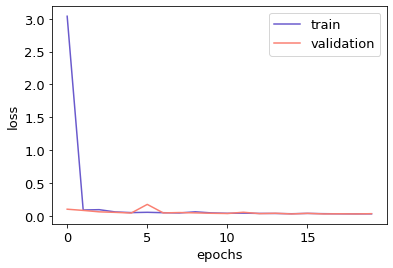

In [13]:
plt.rcParams.update({"font.size": 13})

plt.plot(history.history['loss'], label='train', c='slateblue')
plt.plot(history.history['val_loss'], label='validation', c='salmon')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [14]:
predicted_radius = np.squeeze(model.predict(x_test))
true_radius = y_test

rmse = np.sqrt(model.evaluate(x_test, y_test, verbose=0))
print('Test RMSE: {:.50f}'.format(rmse))

r2 = r2_score(true_radius, predicted_radius)
print('Test R^2: {:.50f}'.format(r2))

Test RMSE: 0.17399058625945210132535123648267472162842750549316
Test R^2: 0.83100647527476678710911528469296172261238098144531


In [15]:
results = pd.DataFrame(np.array([files_names_test, predicted_radius, true_radius]).T, columns=['sys', 'pred', 'true'])
results.head()

,sys,pred,true
0,3111.0,1.812359,1.497
1,6113.0,1.399884,1.442
2,16001.0,1.442858,1.541
3,14954.0,1.882448,1.819
4,19867.0,0.823879,0.806


In [16]:
results.to_csv('./DL_results.txt', index=False)